<br>
<br>

### 0. Create connection & SQLite3 Cursor (a method of the connection object)

In [4]:
import pandas as pd
import sqlite3 # built-in library (Python 2.x & 3.x)

dbpath = "tour_info.db" 

conn = sqlite3.connect(dbpath) # 데이터베이스 파일에 연결(connect)
cur = conn.cursor() # 연결된 데이터베이스를 돌아다닐 커서(cursor) 생성

# conn.cursor(), conn.commit/rollback(), conn.close() <- conn.commit() : 저장 vs conn.rollback() : 마지막 commit 이후의 변경사항 모두 취소 
# cur.execute/executescript/executemany(), cur.fetchone/fetchall()

<br>
<br>

### 1. 여행 정보를 담을 DB TABLE 만들기 (tour_crawl)

In [7]:
script = """
DROP TABLE IF EXISTS tour_crawl;

-- 아래의 테이블 생성 구문을 작성하기 전에 
-- 먼저 DB에 저장할 데이터의 열을 구상한 후 시작해주는 것이 좋습니다.

CREATE TABLE tour_crawl(
  id INTEGER PRIMARY KEY AUTOINCREMENT,  -- 여행 상품의 ID 값
  title TEXT,                            -- 여행 상품의 제목
  price INTEGER,                         -- 여행 상품의 가격
  image TEXT                             -- 여행 상품의 썸네일 이미지 링크
);
""" 
cur.executescript(script) # 한 장의 스크립트(script)를 실행(execute)

script = """
SELECT * FROM tour_crawl;
""" 

df = pd.read_sql_query(script, conn) # 현재 연결(connect)된 데이터베이스로부터 SQL 쿼리를 활용해 데이터를 읽어들입니다.
df.head()

,id,title,price,image


<br>
<br>

### 2. Selenium을 활용해 인터파크 투어 홈페이지에서 여행지를 입력하고 이동

In [7]:
from webdriver_manager.chrome import ChromeDriverManager # 자동으로 크롬드라이버(가상브라우저) 파일을 다운로드해주는 라이브러리
from selenium.webdriver.chrome.service import Service # 다운로드된 크롬드라이버 파일을 연결하기 위해 활용

from selenium import webdriver
import time

import warnings
warnings.filterwarnings("ignore") # 불필요한 Warning 메시지를 꺼줍니다.

In [ ]:
# 활용 중인 개발환경에 따라 Selenium 4.1.0 버전 혹은 Webdriver-manager 3.5.2 버전이 문제를 일으킬 수 있습니다.
# 그러한 경우에는 selenium 버전을 낮추고 아래와 같은 절차를 통해 예전 방식으로 가상브라우저를 띄울 수 있습니다.


# 1. cmd를 관리자권한으로 실행 후, 아래 명령어를 입력하여 Selenium 버전을 다운그레이드합니다.

# pip install selenium==3.11.0


# 2. 아래 코드를 Jupyter notebook에 입력해 가상브라우저를 띄웁니다. ('(driver) chromedriver.exe' 파일이 ipynb 파일 옆에 있어야 합니다.)

# driver = webdriver.Chrome(executable_path='(driver) chromedriver.exe') 


# 3-1. 만약 위 코드 실행 시 [ WebDriverException (cannot find Chrome binary) ] 관련 에러가 발생하면,
#    실제 크롬 브라우저가 설치된 경로를 찾으셔서 아래와 같이 Chrome의 option값을 세팅해주세요. (options.binary_location 변수)

# from selenium.webdriver.chrome.options import Options
# options = Options()
# options.binary_location = "C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe" # 실제 크롬 브라우저 설치 경로를 찾아 변경 후 적용
# driver = webdriver.Chrome(executable_path='(driver) chromedriver.exe', chrome_options=options) # webdriver 실행 시마다 동일하게 작성


# 3-2. 혹은 위와 같은 코드 상의 변경 대신 https://chromedriver.chromium.org/downloads 에서 
#      현재 설치된 크롬 브라우저의 버전과 동일한 버전의 ChromeDriver를 다운로드 받아,
#      코드를 실행하고 있는 ipynb 파일과 동일한 폴더 내의 '(driver) chromedriver.exe' 파일을 대체해주셔도 문제가 해결될 수 있습니다.


# * MacOS의 경우 참고 : Mac OS 환경에서 Selenium Driver Path 설정하기 : https://j.mp/3reMri7

In [8]:
service = Service(executable_path=ChromeDriverManager().install()) 
driver = webdriver.Chrome(service=service)

# driver.maximize_window() # 가상 브라우저를 최대화하고 싶을 때 활용하세요

driver.get('http://tour.interpark.com')
time.sleep(5)

driver.find_element_by_id('SearchGNBText').send_keys('보라카이') # 코로나로 여행상품이 적을 경우 : "태국" 입력
driver.find_element_by_class_name('search-btn').click()
time.sleep(3)

driver.find_element_by_class_name('moreBtn').click()
time.sleep(3)

<br>
<br>

### 4. 여행 상품 목록이 담긴 페이지를 지정한 수 만큼 넘기며 크롤링 & DB 저장

### <span style='color:red;'> 여행 상품의 페이지 수가 3 미만</span>일 경우 에러가 발생합니다. 

1) 아래 Cell에서 **maxpage 변수의 값**(페이지 수)을 자동으로 계산하는 코드의 주석을 풀어 적용하거나,
<br>
2) 아래 Cell에서 **maxpage 변수의 값**을 현재 **여행 상품 페이지 수**와 동일하게 맞추거나,
<br>
3) **driver.close() & driver.quit()** 후, 직전 Cell에서 **여행지를 '미국' 등으로 변경**하고 다시 실행해 내려와주세요.

In [ ]:
# n 페이지에 해당하는 li 태그의 full XPath :
# /html/body/div[3]/div/div[1]/div[2]/div[3]/div[2]/div[3]/ul/li[n]

In [67]:
maxpage = 3
# 페이지 수를 자동으로 계산하는 방식도 가능합니다.
# maxpage = int(driver.find_element_by_class_name('mainTxt').find_element_by_tag_name('span').text) // 10 + 1 

for page in range(1, maxpage + 1):
    
    xpath_page_button = '/html/body/div[3]/div/div[1]/div[2]/div[3]/div[2]/div[3]/ul/li[{}]'
    driver.find_element_by_xpath(xpath_page_button.format(page)).click()
    time.sleep(3) 
    print("\n{}번째 페이지의 크롤링을 시작합니다.\n".format(page))
    
    box_list = driver.find_element_by_id('boxList')
    box_items = box_list.find_elements_by_class_name('boxItem')
    
    for li in box_items:
        title = li.find_element_by_class_name('infoTitle').text 
        price = li.find_element_by_class_name('infoPrice').find_element_by_tag_name('strong').text.replace(',','')
        image = li.find_element_by_tag_name('img').get_attribute('src')
        
        base_sql = "INSERT INTO tour_crawl(title, price, image) values('{}',{},'{}')" # TEXT인 제목은 ''로 감싸주는 것에 유의
        sql_query = base_sql.format(title, price, image) 
        print('SQL Query :', sql_query[:90], "...")
        
        cur.execute(sql_query) # 1건의 SQL Query를 실행(execute)
        conn.commit()

driver.close()
driver.quit()

print('\n크롤링이 정상적으로 종료되었습니다.')


1번째 페이지의 크롤링을 시작합니다.

SQL Query : INSERT INTO tour_crawl(title, price, image) values('[보라카이 4일/5일] 샌즈vs팜비치리조트 핵심일정 + 호핑할인',9 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[보라카이 4일/5일] 헤난리조트 자유일정 + 호핑투어',101100 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[보라카이 4일/5일] 라까멜라리조트 핵심일정 + 호핑할인',6810 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[보라카이 4일/5일] 실속리조트 자유일정 + 호핑투어',701000 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[부산출발_보라카이4/5/6일] 실속리조트 라까멜라+디몰투어+마사지1 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[보라카이 4일/5일] 코코잉글리쉬리조트 핵심일정 + 호핑할인',65 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[보라카이 4일/5일] 가든vs라군리조트 핵심일정 + 호핑할인',91 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[보라카이 4일/5일] 아잘리아리조트 핵심일정 + 호핑할인',7610 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[부산출발_보라카이4/5/6일] 수영장부터 클래스가 다르다. 헤난 크 ...
SQL Query : IN

<br>
<br>

### 5. 저장된 DB 데이터를 불러와 DataFrame으로 확인 

In [68]:
script = """
SELECT * FROM tour_crawl;
""" 

df = pd.read_sql_query(script, conn)
conn.close() # 활용이 모두 끝난 데이터베이스와의 연결은 종료(close)해줍니다.

df.head()

,id,title,price,image
0,1,[보라카이 4일/5일] 샌즈vs팜비치리조트 핵심일정 + 호핑할인,991000,http://tourimage.interpark.com/product/tour/00...
1,2,[보라카이 4일/5일] 헤난리조트 자유일정 + 호핑투어,1011000,http://tourimage.interpark.com/product/tour/00...
2,3,[보라카이 4일/5일] 라까멜라리조트 핵심일정 + 호핑할인,681000,http://tourimage.interpark.com/product/tour/00...
3,4,[보라카이 4일/5일] 실속리조트 자유일정 + 호핑투어,701000,http://tourimage.interpark.com/product/tour/00...
4,5,[부산출발_보라카이4/5/6일] 실속리조트 라까멜라+디몰투어+마사지1시간+호핑선택가능,499000,http://tourimage.interpark.com/product/tour/00...


<br>
<br>

### (extra) URL을 통한 이미지 일괄 다운로드

아래 cell에서 **urllib.request.urlretrieve(URL, "file_name")** 실행 시,
<br>
특정 사이트의 경우 프로그램(Bot)으로 접근하는 것을 차단하여 <span style="color:red;"><b>urllib.error.HTTPError: HTTP Error 403: Forbidden </b></span> 에러가 발생할 수 있습니다.
<br>
이 경우 **아래와 같이 header를 추가**해주세요!


> **opener = urllib.request.build_opener()
<br>
opener.addheaders = [('User-Agent', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
<br>
urllib.request.install_opener(opener)**
<br>
urllib.request.urlretrieve(URL, "file_name")

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import glob
import os
%matplotlib inline


# 이전 크롤링의 결과 images 폴더 안에 남아있는 이미지 파일들이 있다면 모두 삭제해줍니다. 
previous_images = glob.glob('images/*.jpg') # 패턴을 따르는 파일들의 (경로를 포함한)파일명을 리스트로 리턴합니다.
for image in previous_images:
    os.remove(image) # 직접 파일명을 지정하여 파일을 삭제(remove)할 수 있습니다.

# 크롤링한 이미지 URL들을 리스트로 모읍니다.
img_urls = list(df['image'])

# 각 이미지 URL에 대해 다운로드를 진행합니다.
for index, url in enumerate(img_urls): # 주어진 그룹형 변수로부터 index 값까지 한번에 얻어냅니다.
    urllib.request.urlretrieve(url, "images/{}.jpg".format(index)) # 특정 'url'로부터 데이터를 찾아(retrieve) 지정한 파일명으로 저장
    print('Downloaded image # :', index)
    time.sleep(0.3)
    
print('Download completed!')

NameError: name 'df' is not defined

In [8]:
fig = plt.figure(figsize=(15, 15)) 
rows = len(df['image']) // 5 + 1 # 전체 이미지를 5개씩 하나의 행에 보여줄 때 필요한 행의 수
cols = 5
i = 1
 
for filename in glob.glob("images/*.jpg"): # 다운로드가 완료된 전체 파일명 리스트
    
    ax = fig.add_subplot(rows, cols, i) # 지정한 행(rows)과 열(cols)로 구성된 격자 내에서 i번째 plot 영역을 생성
    ax.axis('off') # 불필요한 x & y축을 off
    ax.imshow(Image.open(filename))
    i += 1

plt.tight_layout(pad=0) # 불필요한 여백을 0로 세팅
plt.show()

<Figure size 1500x1500 with 0 Axes>

<br>
<br>

### all-in-one

- 선택된 여행지에 따라 **여행 상품 페이지 수가 3페이지보다 적을 경우** 에러가 발생할 수 있습니다. (페이지 수를 계산하는 코드의 주석을 해제해주세요.)

(1 of 3) 크롤링하고 싶은 여행지를 입력해주세요 : 미국

Current URL : http://tour.interpark.com/

(2 of 3) 미국 여행 상품에 대한 크롤링을 곧 시작합니다.

여행 상품 리스트에 도착했습니다.

1번째 페이지의 크롤링을 시작합니다.

SQL Query : INSERT INTO tour_crawl(title, price, image) values('[미서부 자유 10일] 세도시 샌프란시스코+라스베가스+LA_유나이티드 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[미서부 8일] 샌프란시스코(자유2일)+LA+라스베가스+캐년 투어', ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[시애틀/로키+미서부 12일] 로키산맥/밴쿠버+3대캐년+LA/라스베가 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[시애틀/로키+미동부 15일] 시애틀+밴쿠버+로키+뉴욕+나이아가라+퀘 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[미서동부 완전일주 12일] 2인이상 출발확정+LA+뉴욕+나이아가라_ ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[미동부/캐나다 9일]보스턴 IN/OUT금출발_대한항공',249000 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[테마여행_샌프란시스코 자유 7일] 나파 와인 트레인+버클리+새크라멘 ...
SQL Query : INSERT INTO tour_crawl(title, price, image) values('[미서부&하와이 12일] 4대캐년+3대도시(라스베이거스

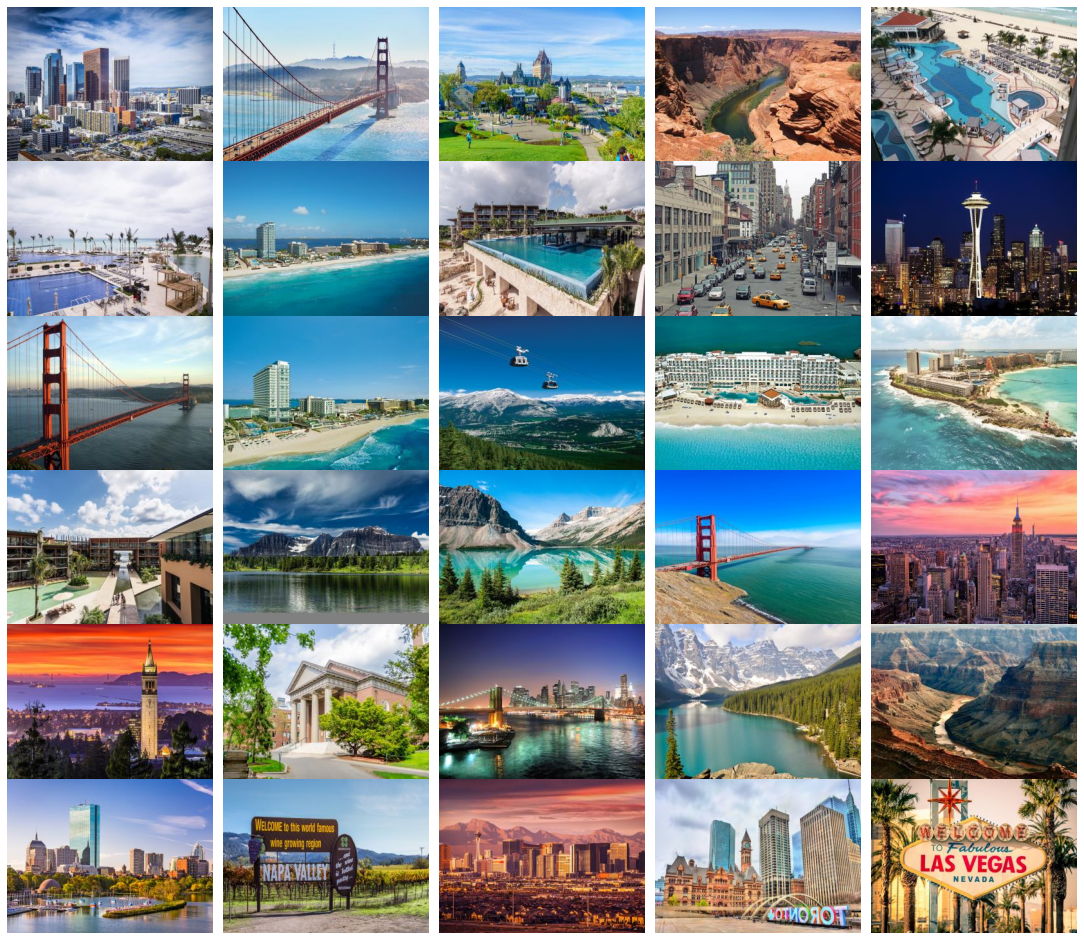

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from selenium import webdriver
import urllib.request
from PIL import Image
import sqlite3 
import time
import glob
import os
%matplotlib inline


def tour_crawl(place='보라카이'):

    dbpath = "tour_info.db" 
    conn = sqlite3.connect(dbpath)
    cur = conn.cursor() 
    
    script = """
    DROP TABLE IF EXISTS tour_crawl;

    CREATE TABLE tour_crawl(
      id INTEGER PRIMARY KEY AUTOINCREMENT,  -- 여행 상품의 ID 값
      title TEXT,                            -- 여행 상품의 제목
      price INTEGER,                         -- 여행 상품의 가격
      image TEXT                             -- 여행 상품의 썸네일 이미지 링크
    );
    """ 
    cur.executescript(script) 
    

    service = Service(executable_path=ChromeDriverManager().install()) 
    driver = webdriver.Chrome(service=service)
    
    driver.get('http://tour.interpark.com')
    print('\nCurrent URL :', driver.current_url)
    time.sleep(5)

    driver.find_element_by_id('SearchGNBText').send_keys(place)
    driver.find_element_by_class_name('search-btn').click()
    print('\n(2 of 3) {} 여행 상품에 대한 크롤링을 곧 시작합니다.'.format(place))
    time.sleep(3)

    driver.find_element_by_class_name('moreBtn').click()
    print('\n여행 상품 리스트에 도착했습니다.')
    time.sleep(3)

    
    maxpage = 3 # 여행 상품의 페이지 수가 3 미만일 경우 에러가 발생합니다.
    # 페이지 수를 자동으로 계산하는 방식도 가능합니다.
    # maxpage = int(driver.find_element_by_class_name('mainTxt').find_element_by_tag_name('span').text) // 10 + 1 
    
    for page in range(1, maxpage + 1):
        
        xpath_page_button = '/html/body/div[3]/div/div[1]/div[2]/div[3]/div[2]/div[3]/ul/li[{}]'
        driver.find_element_by_xpath(xpath_page_button.format(page)).click()
        time.sleep(3) 
        print("\n{}번째 페이지의 크롤링을 시작합니다.\n".format(page))

        box_list = driver.find_element_by_id('boxList')
        box_items = box_list.find_elements_by_class_name('boxItem')

        for li in box_items:
            title = li.find_element_by_class_name('infoTitle').text 
            price = li.find_element_by_class_name('infoPrice').find_element_by_tag_name('strong').text.replace(',','')
            image = li.find_element_by_tag_name('img').get_attribute('src')

            base_sql = "INSERT INTO tour_crawl(title, price, image) values('{}',{},'{}')" # TEXT인 제목은 ''로 감싸주는 것에 유의
            sql_query = base_sql.format(title, price, image) 
            print('SQL Query :', sql_query[:90], "...")

            cur.execute(sql_query)
            conn.commit()

    driver.close()
    driver.quit()

    print('\n총 {}페이지의 크롤링이 정상적으로 종료되었습니다.'.format(page))
    
    
    previous_images = glob.glob('images/*.jpg')
    for image in previous_images:
        os.remove(image)

    
    df = pd.read_sql_query("SELECT image FROM tour_crawl;", conn)
    conn.close()
    img_urls = list(df['image'])
    
    print('\n(3 of 3) 총 {}장의 여행지 이미지에 대한 다운로드를 시작합니다.\n'.format(len(img_urls)))
    
    for index, url in enumerate(img_urls): 
        urllib.request.urlretrieve(url, "images/{}.jpg".format(index)) # 실제 이미지를 다운로드하는 코드 
        time.sleep(0.3)
        if index % 10 == 0:
            print('총 {}장까지 이미지 다운로드가 성공했습니다.'.format(index))

    print('\n모든 이미지의 다운로드가 종료되었습니다! (총 이미지 수 : {})'.format(len(img_urls)))

    
    fig = plt.figure(figsize=(15, 15)) 
    rows = len(df['image']) // 5 + 1 # 전체 이미지를 5개씩 하나의 행에 보여줄 때 필요한 행의 수
    cols = 5
    i = 1

    for filename in glob.glob("images/*.jpg"):

        ax = fig.add_subplot(rows, cols, i)
        ax.axis('off')
        ax.imshow(Image.open(filename))
        i += 1

    plt.tight_layout(pad=0)
    plt.show()
    
    
tour_place = input('(1 of 3) 크롤링하고 싶은 여행지를 입력해주세요 : ')
tour_crawl(tour_place)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d5c3f66-c043-43c9-ab39-85c790f02501' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>